##### Copyright 2019 The TensorFlow Authors. [Licensed under the Apache License, Version 2.0](#scrollTo=y_UVSRtBBsJk).

In [1]:
%install-location $cwd/swift-install
%install '.package(url: "https://github.com/mxcl/Path.swift", from: "0.16.1")' Path
%install '.package(url: "https://github.com/JustHTTP/Just", from: "0.7.1")' Just

Installing packages:
	.package(url: "https://github.com/mxcl/Path.swift", from: "0.16.1")
		Path
	.package(url: "https://github.com/JustHTTP/Just", from: "0.7.1")
		Just
With SwiftPM flags: []
Working in: /tmp/tmpwefcar4q/swift-install
Fetching https://github.com/mxcl/Path.swift
Fetching https://github.com/JustHTTP/Just
Completed resolution in 1.85s
Cloning https://github.com/mxcl/Path.swift
Resolving https://github.com/mxcl/Path.swift at 0.16.2
Cloning https://github.com/JustHTTP/Just
Resolving https://github.com/JustHTTP/Just at 0.7.1
Compile Swift Module 'Path' (9 sources)
Compile Swift Module 'Just' (1 sources)
Compile Swift Module 'jupyterInstalledPackages' (1 sources)
Linking ./.build/x86_64-unknown-linux/debug/libjupyterInstalledPackages.so
Initializing Swift...
Installation complete!


In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
// Licensed under the Apache License, Version 2.0 (the "License");
// you may not use this file except in compliance with the License.
// You may obtain a copy of the License at
//
// https://www.apache.org/licenses/LICENSE-2.0
//
// Unless required by applicable law or agreed to in writing, software
// distributed under the License is distributed on an "AS IS" BASIS,
// WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
// See the License for the specific language governing permissions and
// limitations under the License.

## **Classifying Images of Clothing**

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1XfT75glapWdCp0Zj_4mkiMrjT6odD-Gc"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="Link to be updated"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />GitHub link to be updated accordingly</a>
  </td>
</table>

In this tutorial, we'll build and train a neural network to classify images of clothing, like sneakers and shirts.

It's okay if you don't understand everything. This is a fast-paced overview of a complete S4TF program, with explanations along the way. The goal is to get the general sense of a TensorFlow project, not to catch every detail.

In [0]:
import TensorFlow
import Foundation
import Just
import Path
import Python

%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")
let plt = Python.import("matplotlib.pyplot")
let subprocess = Python.import("subprocess")
let os = Python.import("os")
let np = Python.import("numpy")  // Make numpy available using np.

We will need to gunzip, untar or unzip files we download, so instead of grabbing one library for each, we implement a function that can execute any shell command.

In [0]:
public extension String {
    @discardableResult
    func shell(_ args: String...) -> String
    {
        let (task,pipe) = (Process(),Pipe())
        task.executableURL = URL(fileURLWithPath: self)
        (task.arguments,task.standardOutput) = (args,pipe)
        do    { try task.run() }
        catch { print("Unexpected error: \(error).") }

        let data = pipe.fileHandleForReading.readDataToEndOfFile()
        return String(data: data, encoding: String.Encoding.utf8) ?? ""
    }
}

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset, which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 $\times$ 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc) in an identical format to the articles of clothing we'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code. 

We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images.

In [5]:
public func downloadFile(url: String, destination: String? = nil, force: Bool = false) {
    let destinationName = destination ?? (Path.cwd/url.split(separator: "/").last!).string
    let urlDestination = URL(fileURLWithPath: (destination ?? (Path.cwd/url.split(separator: "/").last!).string))
    if !force && Path(destinationName)!.exists { return }

    print("Downloading \(url)...")

    if let content = Just.get(url).content {
        do    { try content.write(to: URL(fileURLWithPath:destinationName)) }
        catch { print("Can't write to \(urlDestination).\n\(error)") }
    } else {
        print("Can't reach \(url)")
    }
}

let files = ["t10k-images-idx3-ubyte", "t10k-labels-idx1-ubyte", "train-images-idx3-ubyte", "train-labels-idx1-ubyte"]

for file in files {
    downloadFile(url: "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/\(file).gz")
    "/bin/gunzip".shell("-fq", "\(file).gz")
}

In [6]:
let filelist = try FileManager.default.contentsOfDirectory(atPath: ".")
for filename in filelist {
    print(filename)
}

.config
train-labels-idx1-ubyte
t10k-labels-idx1-ubyte
t10k-images-idx3-ubyte
swift-install
train-images-idx3-ubyte
sample_data


Loading the dataset returns metadata as well as a *training dataset* and *test dataset*.

* The model is trained using `trainImages` and `trainNumericLabels`.
* The model is tested against `testImages` and `testNumericLabels`.

The images are 28 $\times$ 28 arrays, with pixel values in the range `[0, 255]`. The *labels* are an array of integers, in the range `[0, 9]`. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th> 
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td> 
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td> 
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td> 
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td> 
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td> 
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td> 
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td> 
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td> 
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td> 
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td> 
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [0]:
let classNames = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

## Reading the data

We need to read the file into an array of bytes which can further be passed to readMNIST function to convert it into a tensor array. \
The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we normalize the image by dividing the pixel value by 255, and then apply it to each image in the test and train datasets. \
The tensor array we create is in the form of NHWC format which is TensorFlow's default. \
N refers to the number of images in a batch. \
H refers to the number of pixels in the vertical (height) dimension. \
W refers to the number of pixels in the horizontal (width) dimension. \
C refers to the channels. For example, 1 for black and white or grayscale and 3 for RGB.

In [0]:
/// Reads a file into an array of bytes.
func readFile(_ path: String) -> [UInt8] {
    let possibleFolders = [".", "MNIST"]
    for folder in possibleFolders {
        let parent = URL(fileURLWithPath: folder)
        let filePath = parent.appendingPathComponent(path)
        guard FileManager.default.fileExists(atPath: filePath.path) else {
            continue
        }
        let data = try! Data(contentsOf: filePath, options: [])
        return [UInt8](data)
    }
    print("File not found: \(path)")
    exit(-1)
}

/// Reads MNIST images and labels from specified file paths.
func readMNIST(imagesFile: String, labelsFile: String) -> (images: Tensor<Float>,
                                                           labels: Tensor<Int32>,
                                                           number: Int) {
    print("Reading data.")
    let images = readFile(imagesFile).dropFirst(16).map(Float.init)
    let labels = readFile(labelsFile).dropFirst(8).map(Int32.init)
    let rowCount = labels.count
    let imageHeight = 28, imageWidth = 28

    print("Constructing data tensors.")
    return (
        images: Tensor(shape: [rowCount, 1, imageHeight, imageWidth], scalars: images)
            .transposed(withPermutations: [0, 2, 3, 1]) / 255, // NHWC
        labels: Tensor(labels),
        number: rowCount
    )
}

### Process the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, and 10000 images in the test set:

In [9]:
let (trainImages, trainNumericLabels, numTrainExamples) = readMNIST(
                                                imagesFile: "train-images-idx3-ubyte",
                                                labelsFile: "train-labels-idx1-ubyte")
let trainLabels = Tensor<Float>(oneHotAtIndices: trainNumericLabels, depth: 10)

let (testImages, testNumericLabels, numTestExamples) = readMNIST(
                                                imagesFile: "t10k-images-idx3-ubyte",
                                                labelsFile: "t10k-labels-idx1-ubyte")
let testLabels = Tensor<Float>(oneHotAtIndices: testNumericLabels, depth: 10)


print("Number of training examples: \(numTrainExamples)")
print("Number of test examples: \(numTestExamples)")

Reading data.
Constructing data tensors.
Reading data.
Constructing data tensors.
Number of training examples: 60000
Number of test examples: 10000


### Explore the processed data

Let's plot an image to see what it looks like.

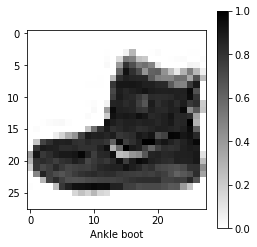

None


In [10]:
let firstTrainImage = trainImages[0]
let firstTrainLabel: Int = Int((trainNumericLabels[0].scalars)[0])
let numpyArray = firstTrainImage.makeNumpyArray().reshape(28, 28)

let cmap = plt.cm.binary
plt.figure(figsize: [4, 4])
plt.imshow(numpyArray, cmap)
plt.colorbar()
plt.grid(false)
plt.xlabel(classNames[firstTrainLabel])
plt.show()

Display the first 25 images from the *training set* and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

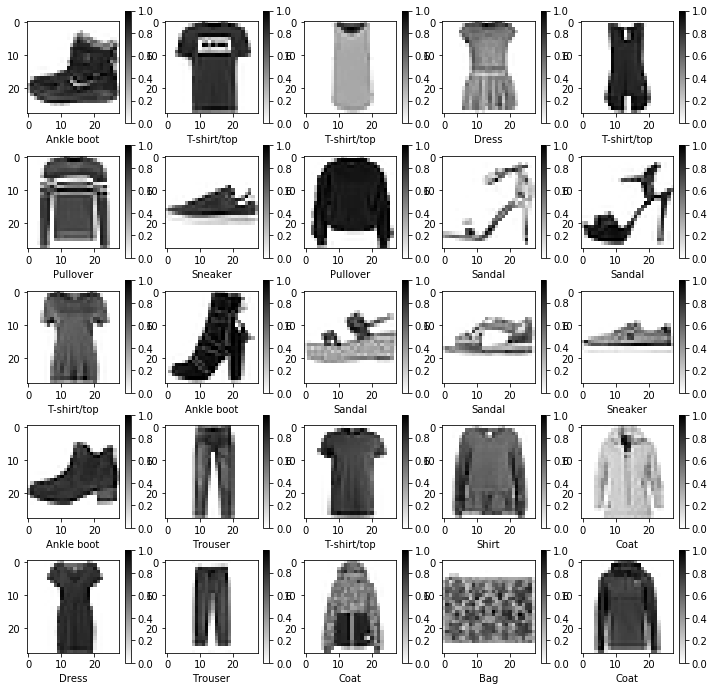

None


In [11]:
plt.figure(figsize: [12, 12])
var dis = 0
for image in 0...24 {
    let TrainImage = trainImages[image]
    let TrainLabel: Int = Int((trainNumericLabels[image].scalars)[0])
    let numpyArray = TrainImage.makeNumpyArray().reshape(28, 28)

    let cmap = plt.cm.binary
    plt.subplot(5,5,dis+1)
    plt.imshow(numpyArray, cmap)
    plt.colorbar()
    plt.grid(false)
    plt.xlabel(classNames[TrainLabel])
    dis += 1
}
plt.show()

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Setup the layers

The basic building block of a neural network is the *layer*. A layer extracts a representation from the data fed into it. Hopefully, a series of connected layers results in a representation that is meaningful for the problem at hand.

Much of deep learning consists of chaining together simple layers. Most layers, like `Dense`, have internal parameters which are adjusted ("learned") during training.

In [0]:
/// A classifier.
struct Classifier: Layer {
    typealias Input = Tensor<Float>
    typealias Output = Tensor<Float>

    var flatten = Flatten<Float>()
    var layer1a = Dense<Float>(inputSize: 28 * 28 * 1, outputSize: 128, activation: relu)
    var layer1b = Dense<Float>(inputSize: 128, outputSize: 10, activation: softmax)

    @differentiable
    func call(_ input: Input) -> Output {
        return input.sequenced(through: flatten, layer1a, layer1b)
    }
}

This network has three layers:

* **input** `Flatten` — This layer transforms the images from a 3d-array of 28 $\times$ 28 $\times$ 1 pixels, to a 1d-array of 784 pixels (28\*28\*1). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn, as it only reformats the data.

* **"hidden"** `Dense`— A densely connected layer of 128 neurons. Each neuron (or node) takes input from all 784 nodes in the previous layer, weighting that input according to hidden parameters which will be learned during training, and outputs a single value to the next layer.

* **output** `Dense` — A 10-node *softmax* layer, with each node representing a class of clothing. As in the previous layer, each node takes input from the 128 nodes in the layer before it. Each node weights the input according to learned parameters, and then outputs a value in the range `[0, 1]`, representing the probability that the image belongs to that class. The sum of all 10 node values is 1.


### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's *compile* step:


* *Loss function* — An algorithm for measuring how far the model's outputs are from the desired output. The goal of training is this measures loss.
* *Optimizer* —An algorithm for adjusting the inner parameters of the model in order to minimize loss.
* *Metrics* —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [0]:
var classifier = Classifier()
let optimizer = Adam(for: classifier)

### Training loop

With all the pieces in place, the model is ready for training! A training loop feeds the dataset examples into the model to help it make better predictions. The following code block sets up these training steps:

1. The `epochCount = 20` parameter limits training to 20 iterations of the training dataset based on minibatches.
2. Within an epoch, iterate over each example in the training `Dataset` grabbing minibatches of Images and labels.
3. Using the example's features, make a prediction and compare it with the label. Measure the inaccuracy of the prediction and use that to calculate the model's loss and gradients.
4. Use Adam Algorithm to update the model's variables.
5. Keep track of some stats for visualization.
6. Repeat for each epoch.

In [0]:
let epochCount = 20
let batchSize = 128

/// Extract a batch of size batchSize
func minibatch<Scalar>(in x: Tensor<Scalar>, at index: Int) -> Tensor<Scalar> {
    let start = index * batchSize
    return x[start..<start+batchSize]
}

In [15]:
print("Beginning training...")

struct Statistics {
    var correctGuessCount: Int = 0
    var totalGuessCount: Int = 0
    var totalLoss: Float = 0
}

// The training loop.
for epoch in 1...epochCount {
    var trainStats = Statistics()
    var testStats = Statistics()
    Context.local.learningPhase = .training
    for i in 0 ..< Int(trainLabels.shape[0]) / batchSize {
        let x = minibatch(in: trainImages, at: i)
        let y = minibatch(in: trainNumericLabels, at: i)
        // Compute the gradient with respect to the model.
        let 𝛁model = classifier.gradient { classifier -> Tensor<Float> in
            let ŷ = classifier(x)
            let correctPredictions = ŷ.argmax(squeezingAxis: 1) .== y
            trainStats.correctGuessCount += Int(
              Tensor<Int32>(correctPredictions).sum().scalarized())
            trainStats.totalGuessCount += batchSize
            let loss = softmaxCrossEntropy(logits: ŷ, labels: y)
            trainStats.totalLoss += loss.scalarized()
            return loss
        }
        // Update the model's differentiable variables along the gradient vector.
        optimizer.update(&classifier.allDifferentiableVariables, along: 𝛁model)
    }

    Context.local.learningPhase = .inference
    for i in 0 ..< Int(testLabels.shape[0]) / batchSize {
        let x = minibatch(in: testImages, at: i)
        let y = minibatch(in: testNumericLabels, at: i)
        // Compute loss on test set
        let ŷ = classifier(x)
        let correctPredictions = ŷ.argmax(squeezingAxis: 1) .== y
        testStats.correctGuessCount += Int(Tensor<Int32>(correctPredictions).sum().scalarized())
        testStats.totalGuessCount += batchSize
        let loss = softmaxCrossEntropy(logits: ŷ, labels: y)
        testStats.totalLoss += loss.scalarized()
    }

    let trainAccuracy = Float(trainStats.correctGuessCount) / Float(trainStats.totalGuessCount)
    let testAccuracy = Float(testStats.correctGuessCount) / Float(testStats.totalGuessCount)
    print("""
          [Epoch \(epoch)] \
          Training Loss: \(trainStats.totalLoss), \
          Training Accuracy: \(trainStats.correctGuessCount)/\(trainStats.totalGuessCount) \ 
          (\(trainAccuracy)), \
          Test Loss: \(testStats.totalLoss), \
          Test Accuracy: \(testStats.correctGuessCount)/\(testStats.totalGuessCount) \
          (\(testAccuracy))
          """)
}

Beginning training...
[Epoch 1] Training Loss: 794.602, Training Accuracy: 46899/59904 (0.78290266), Test Loss: 128.1984, Test Accuracy: 8256/9984 (0.8269231)
[Epoch 2] Training Loss: 760.40643, Training Accuracy: 50595/59904 (0.84460133), Test Loss: 126.85952, Test Accuracy: 8395/9984 (0.84084535)
[Epoch 3] Training Loss: 754.17676, Training Accuracy: 51273/59904 (0.8559195), Test Loss: 127.28125, Test Accuracy: 8316/9984 (0.8329327)
[Epoch 4] Training Loss: 750.4794, Training Accuracy: 51652/59904 (0.8622463), Test Loss: 126.44995, Test Accuracy: 8417/9984 (0.8430489)
[Epoch 5] Training Loss: 747.8919, Training Accuracy: 51952/59904 (0.86725426), Test Loss: 125.627594, Test Accuracy: 8540/9984 (0.8553686)
[Epoch 6] Training Loss: 745.73047, Training Accuracy: 52234/59904 (0.87196183), Test Loss: 125.142914, Test Accuracy: 8582/9984 (0.85957533)
[Epoch 7] Training Loss: 744.49164, Training Accuracy: 52354/59904 (0.873965), Test Loss: 125.10138, Test Accuracy: 8582/9984 (0.85957533)
[E

As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.90 (or 90%) on the training data and 0.87 (or 87%) on the testing data. \
As it turns out, the accuracy on the test dataset is smaller than the accuracy on the training dataset. This is completely normal, since the model was trained on the `trainImages`. When the model sees images it has never seen during training, (that is, from the `testImages`), we can expect performance to go down. 

## Make predictions and explore

With the model trained, we can use it to make predictions about some images.

In [0]:
var x = minibatch(in: trainImages, at: 1)
var y = minibatch(in: trainNumericLabels, at: 1)
let predictions = classifier(x)

In [17]:
print(x.shape)
print(y.shape)
print(predictions.shape)

[128, 28, 28, 1]
[128]
[128, 10]


Here, the model has predicted the label for each image in the minibatch created. Let's take a look at the third prediction:

In [18]:
print(predictions[2])

[ 7.937794e-24, 1.5530443e-28, 5.4642393e-19, 5.8479958e-28,  8.301933e-17, 6.4109486e-19,
 5.4467247e-16, 3.3337827e-18,           1.0,  9.046271e-26]


A prediction is an array of 10 numbers. These describe the "confidence" of the model that the image corresponds to each of the 10 different articles of clothing. We can see which label has the highest confidence value:

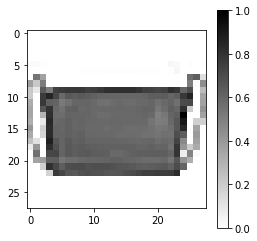

None


In [19]:
let thirdTrainImage = x[2]
let thirdTrainLabel: Int = Int((y[2].scalars)[0])
let numpyArray = thirdTrainImage.makeNumpyArray().reshape(28, 28)

let cmap = plt.cm.binary
plt.figure(figsize: [4, 4])
plt.imshow(numpyArray, cmap)
plt.colorbar()
plt.grid(false)
plt.show()

In [20]:
predictions[2].argmax()

8


So the model is most confident that this image is a Bag, or `classNames[8]`. And we can check the test label to see this is correct:

In [21]:
y[2]

8


We can graph this to look at a set of class predictions

In [0]:
func plotImageStatistics(index: Int, images: Tensor<Float>, predictions: Tensor<Float>, correctLabels: Tensor<Int32>) {
    let numpyImage = images[index].reshaped(to: [28, 28]).makeNumpyArray()
    
    let predictedLabel = predictions[index].makeNumpyArray()
    let predictedLabelIndex = Int((predictions[index].argmax().scalars)[0])
    
    //Correct Label Array with only correct label index as 2, else all as 1
    //This will help in creating a non-overlapping graph with the Predicted Label Array
    let correctLabelIndex = Int((correctLabels[index].scalars)[0])
    let correctLabelArray = np.ones([10], dtype: np.float32)
    correctLabelArray[correctLabelIndex] += 1.0
    
    let cmap = plt.cm.binary
    var color = "blue"
    
    if correctLabelIndex != predictedLabelIndex
    {
        color = "red"
    }
    
    plt.figure(figsize: [6, 3])
    plt.subplot(1,2,1)
    plt.imshow(numpyImage, cmap)
    plt.xlabel("\(classNames[correctLabelIndex]) \(predictedLabel[correctLabelIndex]*100.0)%").set_color(color)
    
    plt.subplot(1,2,2)
    plt.plot(predictedLabel)
    plt.subplot(1,2,2)
    plt.plot(correctLabelArray)
    plt.xlabel("Predicted Label vs Correct Label")
    plt.show()
}

Let's look at the "1" indexed image, predictions, and prediction vs correct label graph. 

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


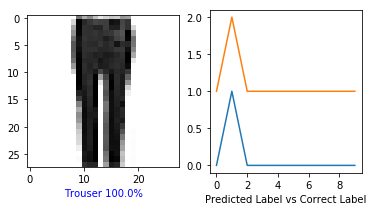

In [23]:
var i = 1
plotImageStatistics(index: i, images: x, predictions: predictions, correctLabels: y)

Let's plot several images with their predictions. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent (out of 100) for the predicted label. Note that it can be wrong even when very confident. 

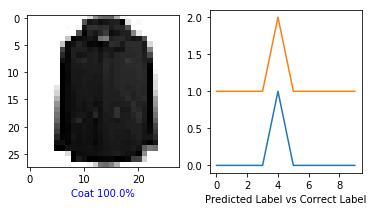

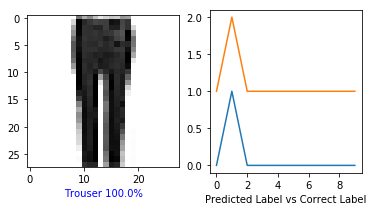

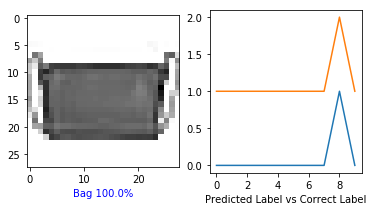

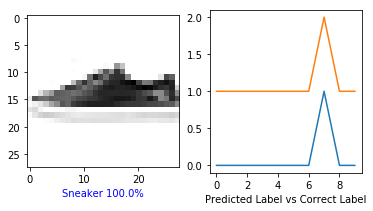

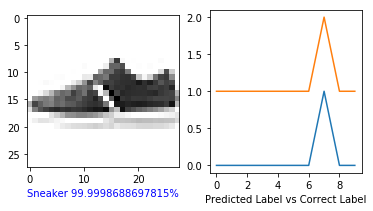

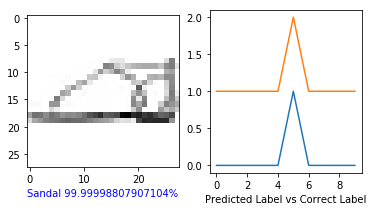

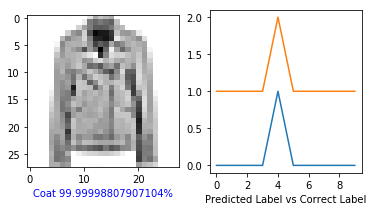

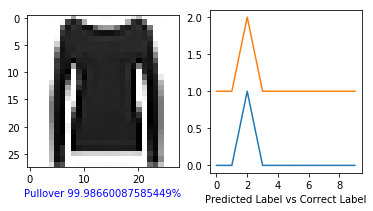

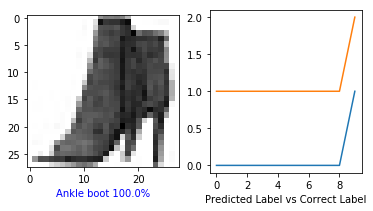

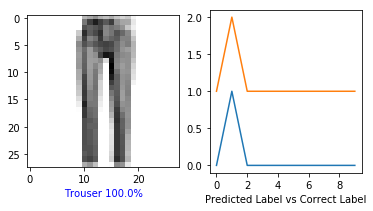

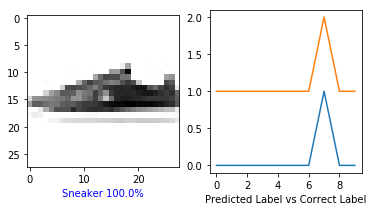

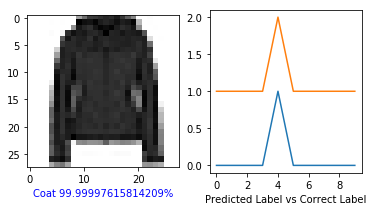

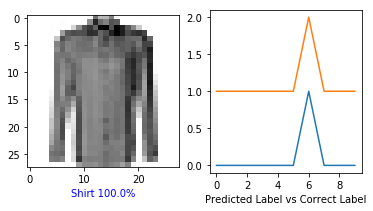

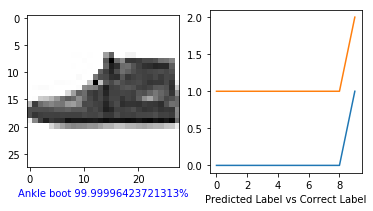

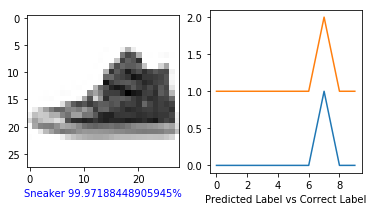

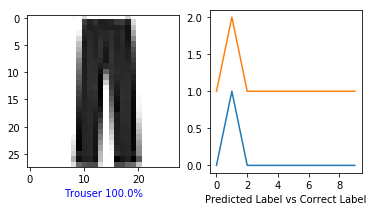

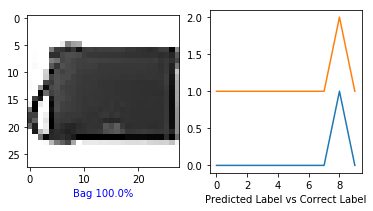

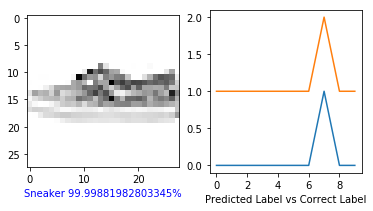

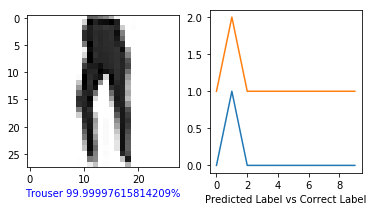

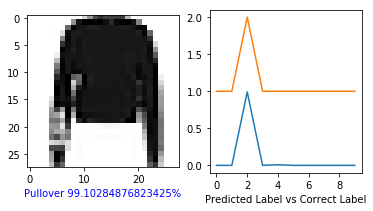

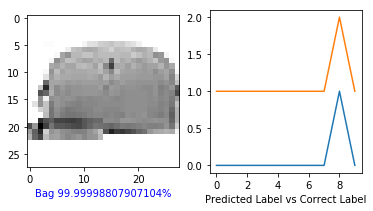

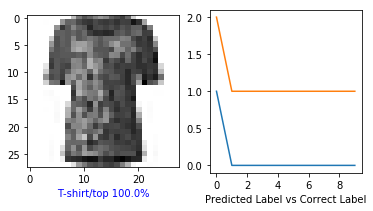

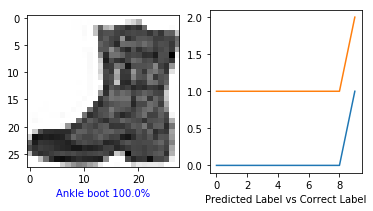

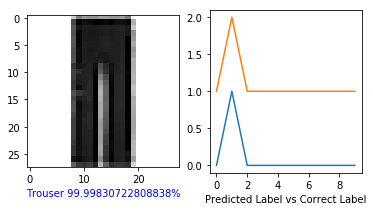

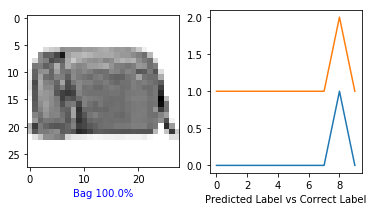

In [24]:
for imgNumber in 0...24 {
    plotImageStatistics(index: imgNumber, images: x, predictions: predictions, correctLabels: y)
}

Finally, use the trained model to make a prediction about a single image. 
Since our classifier takes minibatches as input, we change the first value of our generated minibatch and predict the label for the entire minibatch.

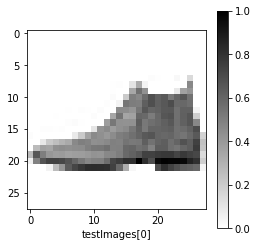

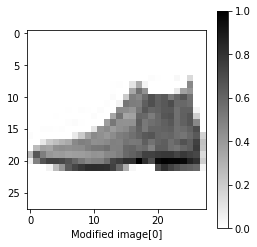

None


In [25]:
//Making a new Image minibatch instead of modifying the originalal minibatch created
var image = x
image[0] = testImages[0]

//Making a new Label minibatch instead of modifying the original minibatch created
let minibatchArray = y.makeNumpyArray()
minibatchArray[0] = PythonObject(Int((testNumericLabels[0].scalars)[0]))
let lbl = Tensor<Int32>(numpy: minibatchArray)!

let cmap = plt.cm.binary

let imgArray = testImages[0].reshaped(to: [28, 28]).makeNumpyArray()
plt.figure(figsize: [4, 4])
plt.imshow(imgArray, cmap)
plt.xlabel("testImages[0]")
plt.colorbar()
plt.grid(false)
plt.show()

let img2Array = image[0].reshaped(to: [28, 28]).makeNumpyArray()
plt.figure(figsize: [4, 4])
plt.imshow(img2Array, cmap)
plt.xlabel("Modified image[0]")
plt.colorbar()
plt.grid(false)
plt.show()

Now predict the image:

In [26]:
let predictionsSingle = classifier(image)
print(predictionsSingle[0])

[ 7.645026e-17,  4.666977e-21, 7.6087784e-16, 3.7091974e-13, 1.6131889e-15,  0.0001035392,
 1.4732172e-10,  7.704248e-05, 2.5385687e-09,    0.99981946]


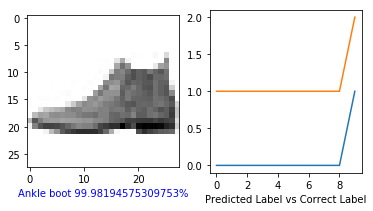

In [27]:
plotImageStatistics(index: 0, images: image, predictions: predictionsSingle, correctLabels: lbl)

classifier(x) returns a list of lists of probabilities, one for each image in the batch of data. Grab the predictions for our (first) image in the batch:

In [28]:
predictionsSingle[0].argmax()

9


And, as before, the model predicts a label of 9 (Ankle Boot).

# Exercises

Experiment with different models and see how the accuracy results differ. In particular change the following parameters:
*   Set training epochs set to 1
*   Number of neurons in the Dense layer following the Flatten one. For example, go really low (e.g. 10) in ranges up to 512 and see how accuracy changes
*   Add additional Dense layers between the Flatten and the final Dense(10,  activation = Softmax), experiment with different units in these layers
*   Don't normalize the pixel values, and see the effect that has


Remember to enable GPU to make everything run faster (Runtime -> Change runtime type -> Hardware accelerator -> GPU).
Also, if you run into trouble, simply reset the entire environment and start from the beginning:
*   Edit -> Clear all outputs
*   Runtime -> Reset all runtimes